# Imports

### Basic imports

In [1]:
import os.path
import pickle # for data serialization
import datetime as dt #for manipulating dates and times
import pandas as pd #for manupulating big data structures
import matplotlib.pyplot as plt #for plotting and visuals of data and results
from pathlib import Path #for os-independent and error catching path

/Users/Sam/.pyenv/versions/3.9.0/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Debug
Uncomment the True, for printing outputs

In [ ]:
#DEBUG = False
DEBUG = True

# Loading the data

In [72]:
tsla = pickle.load(open("data_h.pickle","rb"))
if DEBUG: print(tsla.head(15))
if DEBUG: print("\n Dataframe size = ",tsla.shape)
if DEBUG: print("\n first index = ",tsla.index[0], "; last index = ", tsla.index[-1], "; second index = ",tsla.index[1])
tsla = tsla.drop(['High','Low','Close','Volume','Dividends','Stock Splits'],axis=1) #just gonna look at Open prices for now

                 Open       High        Low      Close   Volume  Dividends  \
Date                                                                         
2019-02-11  62.349998  63.700001  62.135998  63.167999  3140581          0   
2019-02-11  63.153004  63.338001  62.640003  62.902000   876534          0   
2019-02-11  62.935997  63.296001  62.730000  63.250000   801005          0   
2019-02-11  63.230000  63.412640  62.937798  62.956001   563722          0   
2019-02-11  62.996002  63.035999  62.690002  62.840981   513318          0   
2019-02-11  62.826836  62.890003  62.568001  62.796001   453119          0   
2019-02-11  62.770000  62.840004  62.459881  62.570000   642172          0   
2019-02-12  63.230000  63.599998  62.765636  62.964001  1590371          0   
2019-02-12  62.967999  63.430798  62.967999  63.340004   769540          0   
2019-02-12  63.323997  63.355999  62.828003  62.938000   627404          0   
2019-02-12  62.944317  62.984001  61.924000  62.289940  1011159 

# Fixing index
The date indexes need fixing: intra-day observations all have the same index (date. We need to add a time component to them. Trading times for NASDAQ (where TSLA is traded ) is 10 o'clock to 16 o'clock local time. That's 16 to 22 o'clock UTC.

In [69]:
#function that just increments a datetime by 1 hour
def add_hour(x):
    x = x.to_pydatetime() + dt.timedelta(hours=1)
    return pd.Timestamp(x)

First we reset the index, so the dates become a columns that we can manipulated easier.
Then while there are still duplicate dates, we increment the duplicates by one hour.
Once each datetime is unique, we increment them all by and offset to put them to UTC.
Finally we set the datetime back as index.

In [73]:
tsla = tsla.reset_index()

while tsla.duplicated(subset='Date').any() == True:
    tsla_duplicated = tsla.duplicated(subset='Date')
    tsla.loc[tsla_duplicated,'Date'] = tsla[tsla_duplicated]['Date'].apply(add_hour)
    
for i in range(10): #will need to make this 16 in final version
    tsla.loc[:,'Date'] = tsla[:]['Date'].apply(add_hour)
    
tsla.set_index('Date',inplace=True)
    
if DEBUG: print(tsla.head(10))

                          Open
Date                          
2019-02-11 10:00:00  62.349998
2019-02-11 11:00:00  63.153004
2019-02-11 12:00:00  62.935997
2019-02-11 13:00:00  63.230000
2019-02-11 14:00:00  62.996002
2019-02-11 15:00:00  62.826836
2019-02-11 16:00:00  62.770000
2019-02-12 10:00:00  63.230000
2019-02-12 11:00:00  62.967999
2019-02-12 12:00:00  63.323997


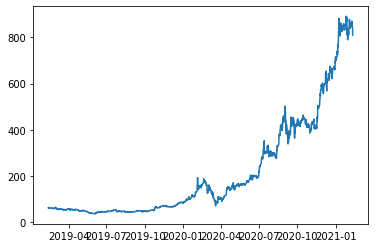

In [77]:
plt.plot(tsla)
plt.xticks(rotation=20)
plt.xlabel('date')
plt.ylabel('price [USD]')
plt.title('Tesla stock price')
plt.show()

Let's make a new file for the corrected prices

In [2]:
file_path = Path('../data/data_h_corrected.pickle')
if DEBUG: print(file_path)
if not os.path.isfile(file_path):
    pickle.dump(tsla,open(file_path,'wb'))

# Google trends variables
## "tesla" search term
### Loading data

In [22]:
search_word='tesla'

tesla_h_path = Path('../data/GoogleTrend_'+search_word+'_hourly.pickle')
tesla_w_path = Path('../data/GoogleTrend_'+search_word+'_weekly.pickle')
tesla_d_path = Path('../data/GoogleTrend_'+search_word+'_daily.pickle')
if DEBUG:
    print(tesla_h_path)
    print('\n',tesla_w_path)
    print('\n',tesla_d_path)
tesla_trend_h = pickle.load(open(tesla_h_path,'rb')).drop(['isPartial'],axis=1)
tesla_trend_w = pickle.load(open(tesla_w_path,'rb')).drop(['isPartial'],axis=1)
tesla_trend_d = pickle.load(open(tesla_d_path,'rb')).drop(['isPartial'],axis=1)

In [10]:
if DEBUG: print(tesla_trend_d.head(23))

            tesla
date             
2020-02-24     96
2020-02-25     92
2020-02-26     91
2020-02-27     95
2020-02-28    100
2020-02-29     80
2020-03-01     74
2020-03-02     86
2020-03-03     93
2020-03-04     80
2020-03-05     82
2020-03-06     86
2020-03-07     75
2020-03-08     66
2020-03-09     98
2020-03-10     90
2020-03-11     81
2020-03-12     87
2020-03-13     84
2020-03-14     68
2020-03-15     61
2020-03-16     84
2020-03-17     80


### First we need to fix the hourly data that has a gap

In [42]:
if DEBUG:
    with pd.option_context('display.max_rows', None):
        print(tesla_trend_h.loc['2020-02-24':'2020-03-17'])

                     tesla  isPartial
date                                 
2020-02-24 00:00:00     90      False
2020-02-24 01:00:00     96      False
2020-02-24 02:00:00     91      False
2020-02-24 03:00:00     80      False
2020-02-24 04:00:00     76      False
2020-02-24 05:00:00     69      False
2020-02-24 06:00:00     63      False
2020-02-24 07:00:00     64      False
2020-02-24 08:00:00     67      False
2020-02-24 09:00:00     69      False
2020-02-24 10:00:00     70      False
2020-02-24 11:00:00     74      False
2020-02-24 12:00:00      0      False
2020-02-24 13:00:00      0      False
2020-02-24 14:00:00      0      False
2020-02-24 15:00:00      0      False
2020-02-24 16:00:00      0      False
2020-02-24 17:00:00      0      False
2020-02-24 18:00:00      0      False
2020-02-24 19:00:00      0      False
2020-02-24 20:00:00      0      False
2020-02-24 21:00:00      0      False
2020-02-24 22:00:00      0      False
2020-02-24 23:00:00      0      False
2020-02-25 0

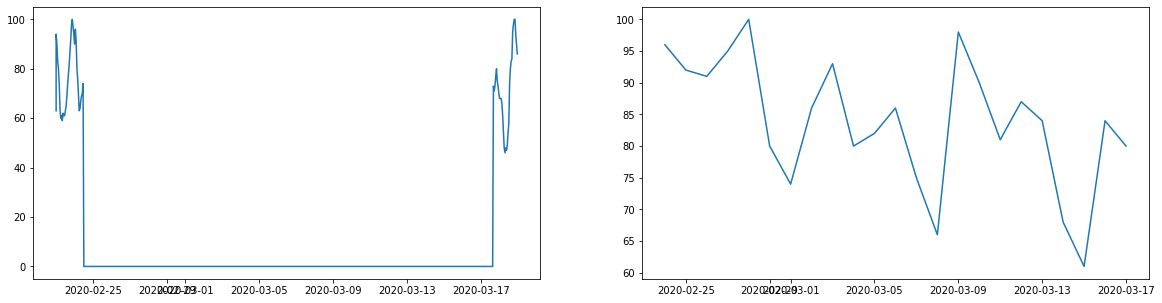

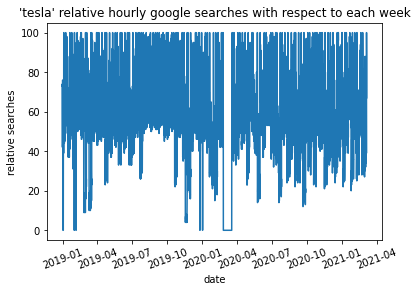

In [25]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(tesla_trend_h[search_word]['2020-02-23':'2020-03-18'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches, problematic area")

axs[1].plot(tesla_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches, problematic area")
plt.show()

plt.plot(tesla_trend_h[search_word])
plt.ylabel("relative searches [%]")
plt.xlabel("date")
plt.xticks(rotation=20)
plt.title("'"+search_word+"' relative hourly google searches with respect to each week")

img_GT_tesla_raw = Path("../report/img/img_GT_tesla_raw.pdf")
plt.savefig(img_GT_tesla_raw,bbox_inches="tight")

plt.show()

In [19]:
print('hourly sum on 24th: ', sum(tesla_trend_h['tesla']['2020-02-24']))
print('hourly sum on 17th: ', sum(tesla_trend_h['tesla']['2020-03-17']))

hourly sum on 24th:  909
hourly sum on 17th:  592


Now we implant the daily values for the faulty hourly values

In [11]:
#for idx in tesla_trend_h['tesla']['2020-02-24T12':'2020-03-17T15'].index:
#    print(idx)
#    if tesla_trend_h['tesla'][idx] == 0:
#        print('old value: ',tesla_trend_h.at[idx,'tesla'])
#        print('new value: ',tesla_trend_d['tesla'][idx.floor('D')])

part1 = tesla_trend_h.loc[:'2020-02-24T11']
part3 = tesla_trend_h.loc['2020-03-17T16':]
part2 = pd.DataFrame(columns=[search_word])

start_dt, end_dt = pd.to_datetime('2020-02-24T12'), pd.to_datetime('2020-03-17T15')
idx = start_dt
while idx <= end_dt:
    part2.loc[pd.Timestamp(idx)] = [tesla_trend_d[search_word][pd.Timestamp(idx).floor('D')]]
    #if idx in tesla_trend_h.index:
    #    print('old : ', tesla_trend_h['tesla'][idx])
    #else:
    #    print('old : NaN')
    #print('new : ',tesla_trend_d['tesla'][pd.Timestamp(idx).floor('D')])
    idx = idx + dt.timedelta(hours=1)

We now put the dataframe back together and see what it looks like

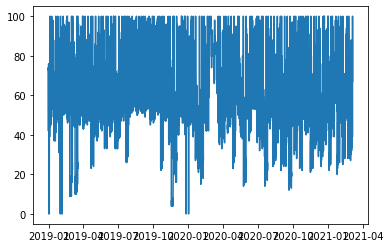

In [12]:
new_h = pd.concat([part1,part2,part3])

plt.plot(new_h)
plt.xticks(rotation=20)
plt.xlabel('date')
plt.ylabel('relative searches [%]')
plt.title("'"+search_word+"' corrected hourly searches")
plt.show()

It's not perfect, we can tell that there is something different compared to the rest of the series, but it's better than before, so we'll go with it. Let's zoom a little.

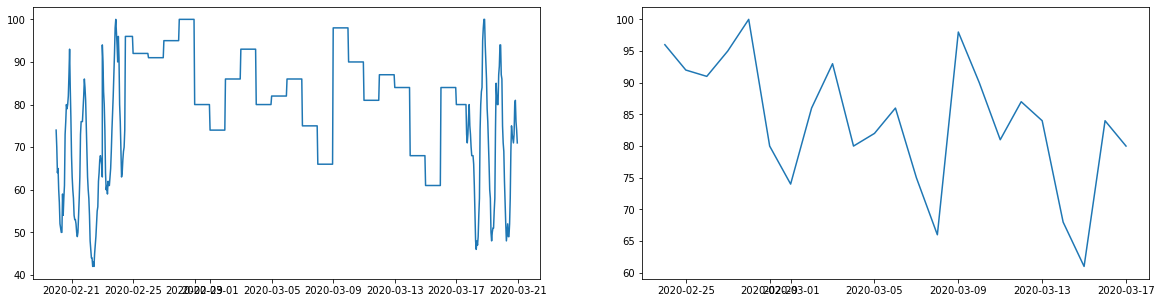

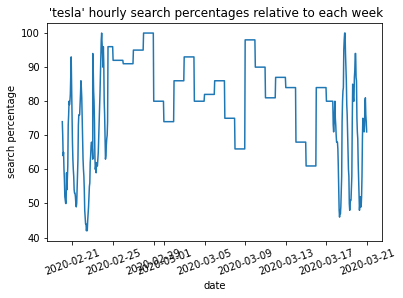

In [15]:
fig, axs = plt.subplots(1,2,figsize=(20,5))
axs[0].plot(new_h[search_word]['2020-02-20':'2020-03-20'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches, problematic area")

axs[1].plot(tesla_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches, problematic area")

plt.show()

plt.plot(new_h[search_word]['2020-02-20':'2020-03-20'])
plt.xlabel("date")
plt.xticks(rotation=20)
plt.ylabel("relative searches [%]")
plt.title(" '"+search_word+"' hourly search percentages relative to each week")

img_GT_tesla_probarea = Path("../report/img/img_GT_tesla_probarea.pdf")
if DEBUG: print(file_path)
plt.savefig(img_GT_tesla_probarea,bbox_inches="tight")

plt.show()


### Now we have to compose the hourly values, which is just an agreggation of the weekly hourly values, which the weekly values, in order to get true hourly search percentages over the entire time frame

We will do this by multiplying the hourly value with the weekly value.

In [16]:
tesla_trend_w = tesla_trend_w.div(100)
print(tesla_trend_w.head())

            tesla
date             
2016-03-20   0.17
2016-03-27   0.69
2016-04-03   0.47
2016-04-10   0.25
2016-04-17   0.21


In [17]:
new_h = new_h.div(100)

In [112]:
print(new_h.head())

                    tesla
2018-12-30 00:00:00  0.73
2018-12-30 01:00:00  0.74
2018-12-30 02:00:00  0.64
2018-12-30 03:00:00  0.65
2018-12-30 04:00:00  0.61


In [18]:
final_h = new_h.copy()
for h_idx in new_h.index:
    h_val = new_h[search_word][h_idx]
    w_val = tesla_trend_w[search_word][h_idx>=tesla_trend_w.index][-1]
    if DEBUG: print(w_val)
    final_h[search_word][h_idx] = h_val*w_val*100

Let's check the if the new granular data seems coherent vs the less granular weekly data

                     tesla
2018-12-30 00:00:00  19.71
2018-12-30 01:00:00  19.98
2018-12-30 02:00:00  17.28
2018-12-30 03:00:00  17.55
2018-12-30 04:00:00  16.47
...                    ...
2021-03-05 20:00:00  46.98
2021-03-05 21:00:00  46.44
2021-03-05 22:00:00  42.12
2021-03-05 23:00:00  38.34
2021-03-06 00:00:00  36.18

[19239 rows x 1 columns]


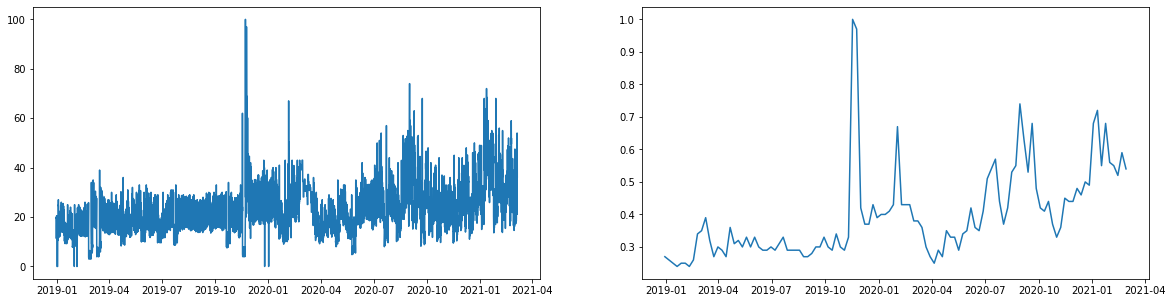

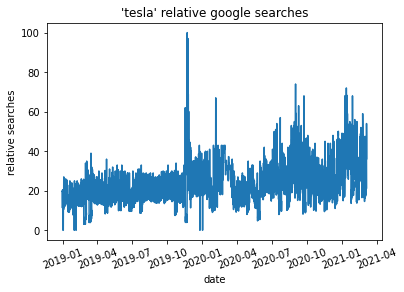

In [21]:
if DEBUG: print(final_h)
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(final_h[search_word])
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches relative to full period")

axs[1].plot(tesla_trend_w[search_word]['2018-12-30':'2021-03-06'])
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' weekly searches relative to full period")

plt.show()

plt.plot(final_h[search_word])
plt.xlabel('date')
plt.xticks(rotation=20)
plt.ylabel('relative searches')
plt.title("'"+search_word+"' relative google searches")

img_GT_tesla = Path("../report/img/img_GT_tesla.pdf")
if DEBUG: print(file_path)
plt.savefig(img_GT_tesla,bbox_inches="tight")

plt.show()


Export the new series

In [118]:
file_path = Path('../data/GT_tesla_h.pickle')
if DEBUG: print(file_path)
if not os.path.isfile(file_path):
    pickle.dump(final_h,open(file_path,'wb'))

## Google trends "tsla"
rinse ans repeat with the other search words

In [120]:
search_word = 'tsla'

tsla_h_path = Path('../data/GoogleTrend_'+search_word+'_hourly.pickle')
tsla_w_path = Path('../data/GoogleTrend_'+search_word+'_weekly.pickle')
tsla_d_path = Path('../data/GoogleTrend_'+search_word+'_daily.pickle')
if DEBUG:
    print(tsla_h_path)
    print('\n'+tsla_w_path)
    print('\n'+tsla_d_path)
tsla_trend_h = pickle.load(open(tsla_h_path,'rb')).drop(['isPartial'],axis=1)
tsla_trend_w = pickle.load(open(tsla_w_path,'rb')).drop(['isPartial'],axis=1)
tsla_trend_d = pickle.load(open(tsla_d_path,'rb')).drop(['isPartial'],axis=1)

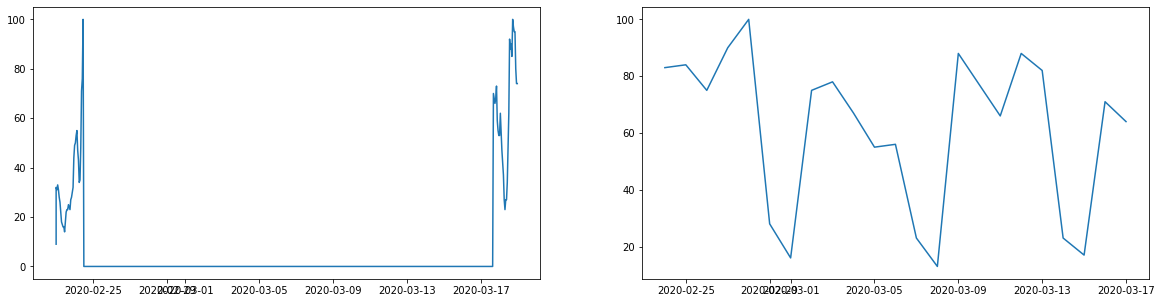

In [121]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(tsla_trend_h[search_word]['2020-02-23':'2020-03-18'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly relative searches problematic area")

axs[1].plot(tsla_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily relative searches problematic area")

plt.show()

Splitting the data

In [122]:
part1 = tsla_trend_h.loc[:'2020-02-24T11']
part3 = tsla_trend_h.loc['2020-03-17T16':]
part2 = pd.DataFrame(columns=[search_word])

start_dt, end_dt = pd.to_datetime('2020-02-24T12'), pd.to_datetime('2020-03-17T15')
idx = start_dt
while idx <= end_dt:
    part2.loc[pd.Timestamp(idx)] = [tsla_trend_d[search_word][pd.Timestamp(idx).floor('D')]]
    idx = idx + dt.timedelta(hours=1)

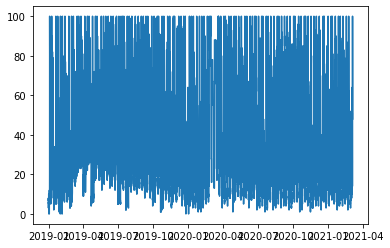

In [123]:
new_h = pd.concat([part1,part2,part3])

plt.plot(new_h)
plt.xticks(rotation=20)
plt.xlabel('date')
plt.ylabel('relative searches [%]')
plt.title("'"+search_word+"' hourly searches fixed")

plt.show()

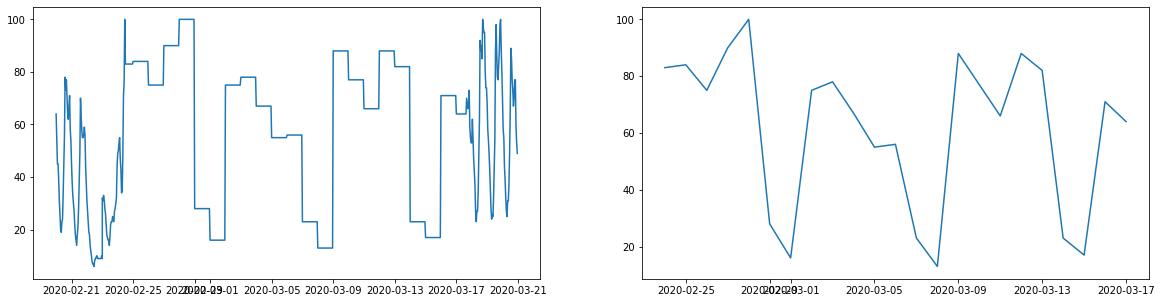

In [124]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(new_h[search_word]['2020-02-20':'2020-03-20'])
axs[0].xticks(rotation=20)
axs[0].xlabel('date')
axs[0].ylabel('relative searches [%]')
axs[0].title("'"+search_word+"' hourly searches fixed zoomed")

axs[1].plot(tsla_trend_d[search_word])
axs[1].xticks(rotation=20)
axs[1].xlabel('date')
axs[1].ylabel('relative searches [%]')
axs[1].title("'"+search_word+"' daily searches")

plt.show()

In [125]:
tsla_trend_w = tsla_trend_w.div(100)
print(tsla_trend_w.head())

            tsla
date            
2016-03-27  0.13
2016-04-03  0.14
2016-04-10  0.07
2016-04-17  0.05
2016-04-24  0.05


In [126]:
new_h = new_h.div(100)
print(new_h.head())

                     tsla
2018-12-30 00:00:00  0.07
2018-12-30 01:00:00  0.08
2018-12-30 02:00:00  0.07
2018-12-30 03:00:00  0.07
2018-12-30 04:00:00  0.08


In [127]:
final_h = new_h.copy()
for h_idx in new_h.index:
    h_val = new_h[search_word][h_idx]
    w_val = tsla_trend_w[search_word][h_idx>=tsla_trend_w.index][-1]
    if DEBUG: print(w_val)
    final_h[search_word][h_idx] = h_val*w_val*100

                      tsla
2018-12-30 00:00:00   0.77
2018-12-30 01:00:00   0.88
2018-12-30 02:00:00   0.77
2018-12-30 03:00:00   0.77
2018-12-30 04:00:00   0.88
...                    ...
2021-03-05 20:00:00  38.76
2021-03-05 21:00:00  36.21
2021-03-05 22:00:00   30.6
2021-03-05 23:00:00  28.05
2021-03-06 00:00:00  24.48

[19239 rows x 1 columns]


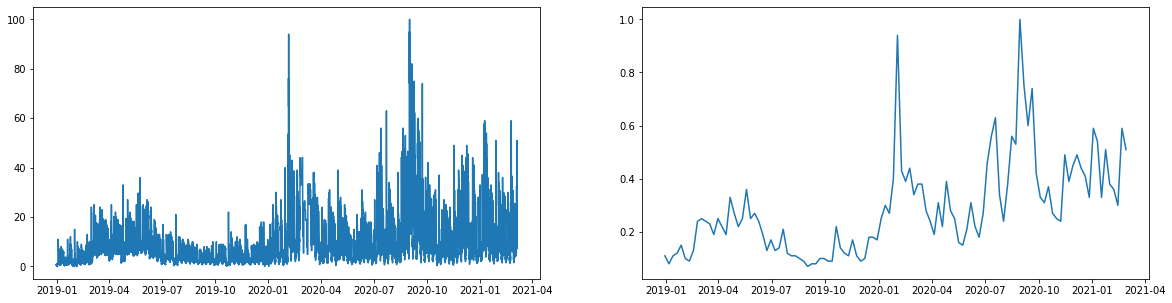

In [128]:
print(final_h)
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(final_h[search_word])
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches relative to period")

axs[1].plot(tsla_trend_w[search_word]['2018-12-30':'2021-03-06'])
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' weekly searches relative to period")

plt.show()

In [129]:
file_path = Path('../data/GT_tsla_h.pickle')
if DEBUG: print(file_path)
if not os.path.isfile(file_path):
    pickle.dump(final_h,open(file_path,'wb'))

## Google Trends "musk"
rinse and repeat

In [130]:
search_word = 'musk'

musk_h_path = Path('../data/GoogleTrend_'+search_word+'_hourly.pickle')
musk_w_path = Path('../data/GoogleTrend_'+search_word+'_weekly.pickle')
musk_d_path = Path('../data/GoogleTrend_'+search_word+'_daily.pickle')
if DEBUG:
    print(musk_h_path)
    print('\n'+musk_w_path)
    print('\n'+musk_d_path)
musk_trend_h = pickle.load(open(musk_h_path,'rb')).drop(['isPartial'],axis=1)
musk_trend_w = pickle.load(open(musk_w_path,'rb')).drop(['isPartial'],axis=1)
musk_trend_d = pickle.load(open(musk_d_path,'rb')).drop(['isPartial'],axis=1)

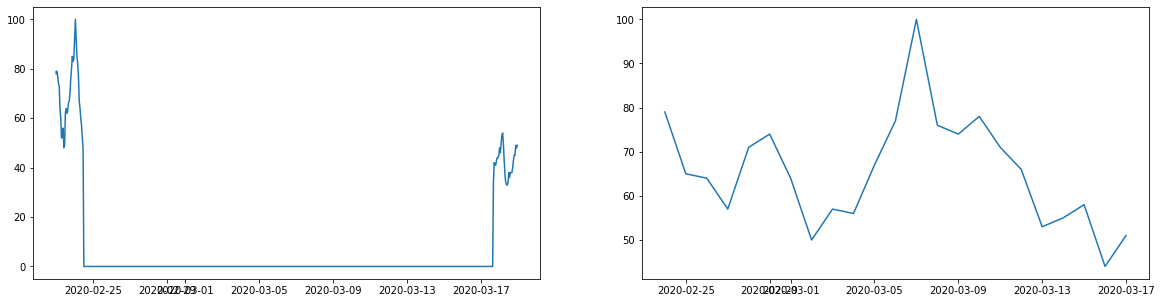

In [131]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(musk_trend_h[search_word]['2020-02-23':'2020-03-18'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches, problematic area")

axs[1].plot(musk_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches, problematic area")

plt.show()

In [133]:
part1 = musk_trend_h.loc[:'2020-02-24T11']
part3 = musk_trend_h.loc['2020-03-17T16':]
part2 = pd.DataFrame(columns=[search_word])

start_dt, end_dt = pd.to_datetime('2020-02-24T12'), pd.to_datetime('2020-03-17T15')
idx = start_dt
while idx <= end_dt:
    part2.loc[pd.Timestamp(idx)] = [musk_trend_d[search_word][pd.Timestamp(idx).floor('D')]]
    idx = idx + dt.timedelta(hours=1)

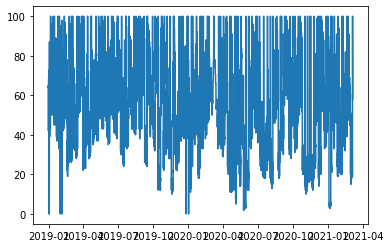

In [134]:
new_h = pd.concat([part1,part2,part3])

plt.plot(new_h)
plt.xticks(rotation=20)
plt.xlabel('date')
plt.ylabel('relative searches [%]')
plt.title("'"+search_word+"' hourly searches corrected")
plt.show()

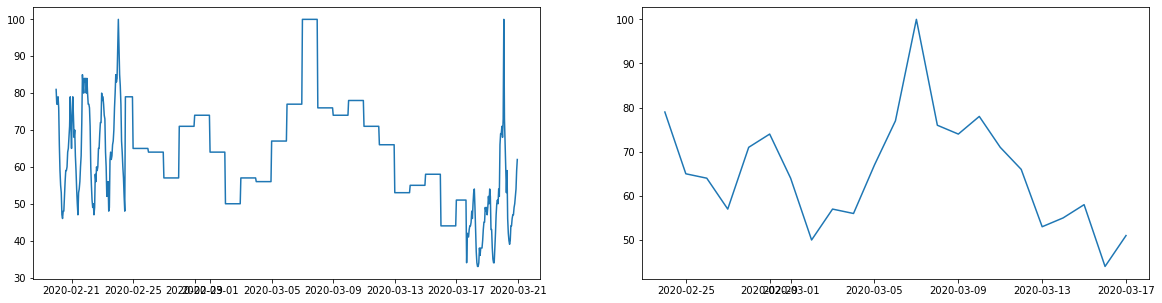

In [135]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(new_h[search_word]['2020-02-20':'2020-03-20'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches corrected zoomed")

axs[1].plot(musk_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches zoomed")

plt.show()

In [136]:
musk_trend_w = musk_trend_w.div(100)
print(musk_trend_w.head())

            musk
date            
2016-03-27  0.05
2016-04-03  0.06
2016-04-10  0.04
2016-04-17  0.04
2016-04-24  0.04


In [137]:
new_h = new_h.div(100)
print(new_h.head())

                     musk
2018-12-30 00:00:00  0.64
2018-12-30 01:00:00   0.6
2018-12-30 02:00:00  0.62
2018-12-30 03:00:00  0.65
2018-12-30 04:00:00   0.6


In [139]:
final_h = new_h.copy()
for h_idx in new_h.index:
    h_val = new_h[search_word][h_idx]
    w_val = musk_trend_w[search_word][h_idx>=musk_trend_w.index][-1]
    if DEBUG: print(w_val)
    final_h[search_word][h_idx] = h_val*w_val*100

                      musk
2018-12-30 00:00:00   5.12
2018-12-30 01:00:00    4.8
2018-12-30 02:00:00   4.96
2018-12-30 03:00:00    5.2
2018-12-30 04:00:00    4.8
...                    ...
2021-03-05 20:00:00  16.72
2021-03-05 21:00:00  17.38
2021-03-05 22:00:00  18.26
2021-03-05 23:00:00  15.84
2021-03-06 00:00:00  12.76

[19239 rows x 1 columns]


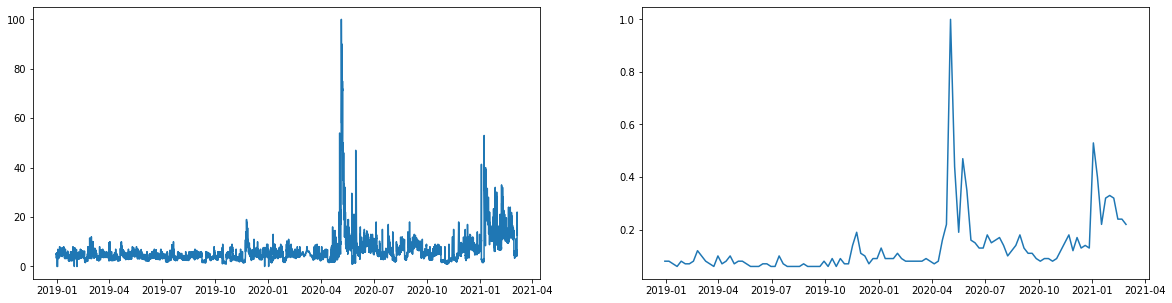

In [140]:
print(final_h)
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(final_h[search_word])
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches relative to period")

axs[1].plot(musk_trend_w[search_word]['2018-12-30':'2021-03-06'])
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' weekly searches relative to period")

plt.show()

In [141]:
file_path = Path('../data/GT_musk_h.pickle')
if DEBUG: print(file_path)
if not os.path.isfile(file_path):
    pickle.dump(final_h,open(file_path,'wb'))

# Google Trends "tesla stock"

In [142]:
search_word = 'tesla stock'

ts_h_path = Path('../data/GoogleTrend_'+search_word.replace(" ","_")+'_hourly.pickle')
ts_w_path = Path('../data/GoogleTrend_'+search_word.replace(" ","_")+'_weekly.pickle')
ts_d_path = Path('../data/GoogleTrend_'+search_word.replace(" ","_")+'_daily.pickle')
if DEBUG:
    print(ts_h_path)
    print('\n'+ts_w_path)
    print('\n'+ts_d_path)
ts_trend_h = pickle.load(open(ts_h_path,'rb')).drop(['isPartial'],axis=1)
ts_trend_w = pickle.load(open(ts_w_path,'rb')).drop(['isPartial'],axis=1)
ts_trend_d = pickle.load(open(ts_d_path,'rb')).drop(['isPartial'],axis=1)

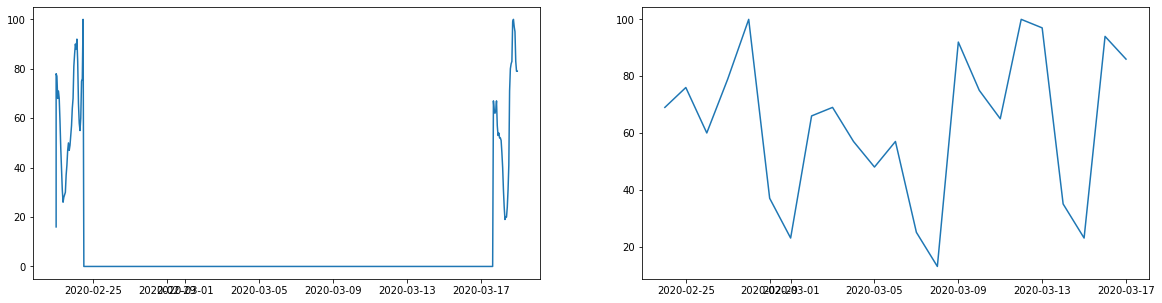

In [143]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(ts_trend_h[search_word]['2020-02-23':'2020-03-18'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches, problematic area")

axs[1].plot(ts_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches, problematic area")

plt.show()

In [144]:
part1 = ts_trend_h.loc[:'2020-02-24T11']
part3 = ts_trend_h.loc['2020-03-17T16':]
part2 = pd.DataFrame(columns=[search_word])

start_dt, end_dt = pd.to_datetime('2020-02-24T12'), pd.to_datetime('2020-03-17T15')
idx = start_dt
while idx <= end_dt:
    part2.loc[pd.Timestamp(idx)] = [ts_trend_d[search_word][pd.Timestamp(idx).floor('D')]]
    idx = idx + dt.timedelta(hours=1)

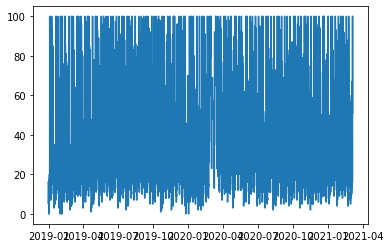

In [145]:
new_h = pd.concat([part1,part2,part3])

plt.plot(new_h)
plt.xticks(rotation=20)
plt.xlabel('date')
plt.ylabel('relative searches [%]')
plt.title("'"+search_word+"' hourly searches corrected")

plt.show()

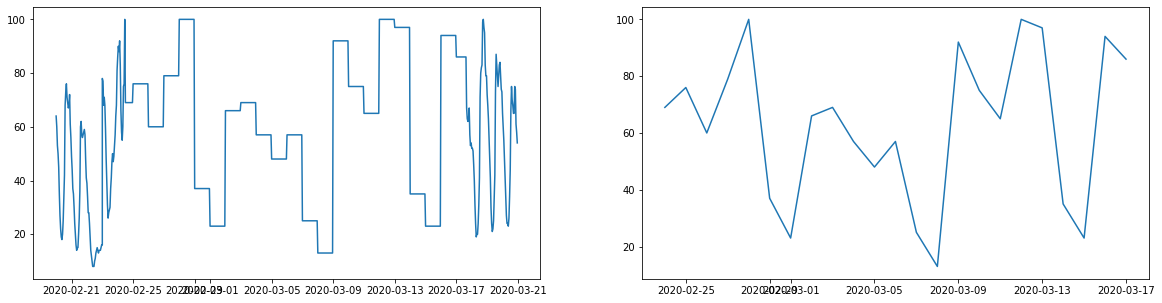

In [146]:
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(new_h[search_word]['2020-02-20':'2020-03-20'])
axs[0].set_xticks(rotation=20)
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches corrected zoomed to problem area")

axs[1].plot(ts_trend_d[search_word])
axs[1].set_xticks(rotation=20)
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches zoomed to problem area")

plt.show()

In [147]:
ts_trend_w = ts_trend_w.div(100)
print(ts_trend_w.head())

            tesla stock
date                   
2016-03-27         0.07
2016-04-03         0.07
2016-04-10         0.03
2016-04-17         0.03
2016-04-24         0.02


In [148]:
new_h = new_h.div(100)
print(new_h.head())

                    tesla stock
2018-12-30 00:00:00        0.16
2018-12-30 01:00:00        0.16
2018-12-30 02:00:00        0.13
2018-12-30 03:00:00        0.14
2018-12-30 04:00:00        0.14


In [149]:
final_h = new_h.copy()
for h_idx in new_h.index:
    h_val = new_h[search_word][h_idx]
    w_val = ts_trend_w[search_word][h_idx>=ts_trend_w.index][-1]
    if DEBUG:print(w_val)
    final_h[search_word][h_idx] = h_val*w_val*100

                    tesla stock
2018-12-30 00:00:00         0.8
2018-12-30 01:00:00         0.8
2018-12-30 02:00:00        0.65
2018-12-30 03:00:00         0.7
2018-12-30 04:00:00         0.7
...                         ...
2021-03-05 20:00:00       38.22
2021-03-05 21:00:00       36.26
2021-03-05 22:00:00       30.38
2021-03-05 23:00:00       27.44
2021-03-06 00:00:00       24.99

[19239 rows x 1 columns]


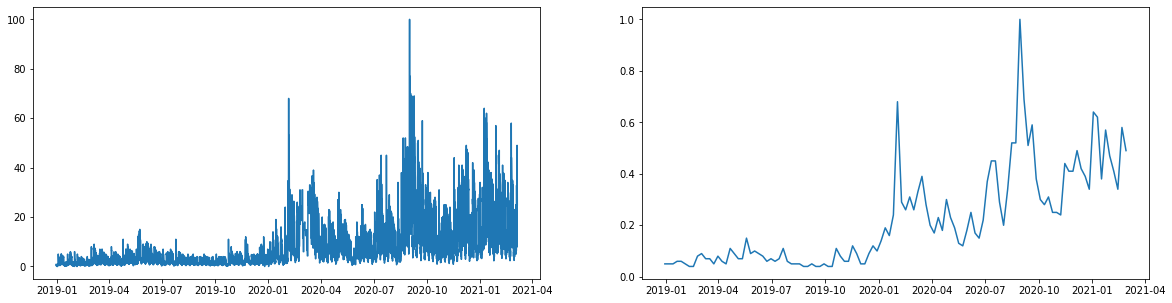

In [150]:
print(final_h)
fig, axs = plt.subplots(1,2,figsize=(20,5))

axs[0].plot(final_h[search_word])
axs[0].set_xlabel('date')
axs[0].set_ylabel('relative searches [%]')
axs[0].set_title("'"+search_word+"' hourly searches relative to period")

axs[1].plot(ts_trend_w[search_word]['2018-12-30':'2021-03-06'])
axs[1].set_xlabel('date')
axs[1].set_ylabel('relative searches [%]')
axs[1].set_title("'"+search_word+"' daily searches relative to period")

plt.show()

In [151]:
file_path = Path('../data/GT_tesla_stock_h.pickle')
if DEBUG: print(file_path)
if not os.path.isfile(file_path):
    pickle.dump(final_h,open(file_path,'wb'))

# USD inflation data

Could the stock price increase be partly or exclusevly due to inflation ?

In [5]:
infl = pd.read_csv("../data/T10YIE.csv")
print(infl)

            DATE T10YIE
0     2008-07-25   2.34
1     2008-07-28   2.36
2     2008-07-29   2.33
3     2008-07-30   2.36
4     2008-07-31   2.34
...          ...    ...
3293  2021-03-10   2.26
3294  2021-03-11   2.28
3295  2021-03-12   2.26
3296  2021-03-15   2.27
3297  2021-03-16    2.3

[3298 rows x 2 columns]


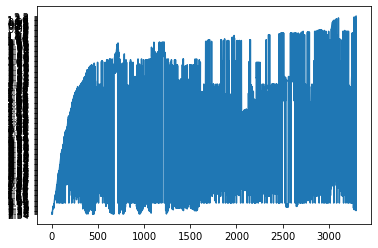

In [8]:
plt.plot(infl['T10YIE'])

# Twitter Musk

In [2]:
tweets_musk = pickle.load(open('../data/twitter_musk_full.pickle','rb'))

In [3]:
print('nbr of tweets',len(tweets_musk))
print('first tweet: ',tweets_musk.iloc[-1].created_at,'    Last tweet: ',tweets_musk.iloc[0].created_at)
print(tweets_musk.head())

nbr of tweets 7857
first tweet:  2019-01-01T00:20:48.000Z     Last tweet:  2021-04-28T08:54:22.000Z
                 created_at  \
0  2021-04-28T08:54:22.000Z   
1  2021-04-28T08:51:43.000Z   
2  2021-04-28T08:43:37.000Z   
3  2021-04-28T07:33:33.000Z   
4  2021-04-28T06:21:41.000Z   

                                      public_metrics                   id  \
0  {'retweet_count': 202, 'reply_count': 200, 'li...  1387329332541104131   
1  {'retweet_count': 131, 'reply_count': 218, 'li...  1387328662073188353   
2  {'retweet_count': 2781, 'reply_count': 5728, '...  1387326627160408067   
3  {'retweet_count': 135, 'reply_count': 244, 'li...  1387308991743672322   
4  {'retweet_count': 239, 'reply_count': 263, 'li...  1387290907108679680   

                                                text author_id  retweet_count  \
0  @RationalEtienne @Erdayastronaut @Twisi80 Star...  44196397            202   
1                @RiusJulien https://t.co/paTKsQjNp8  44196397            131   
2      

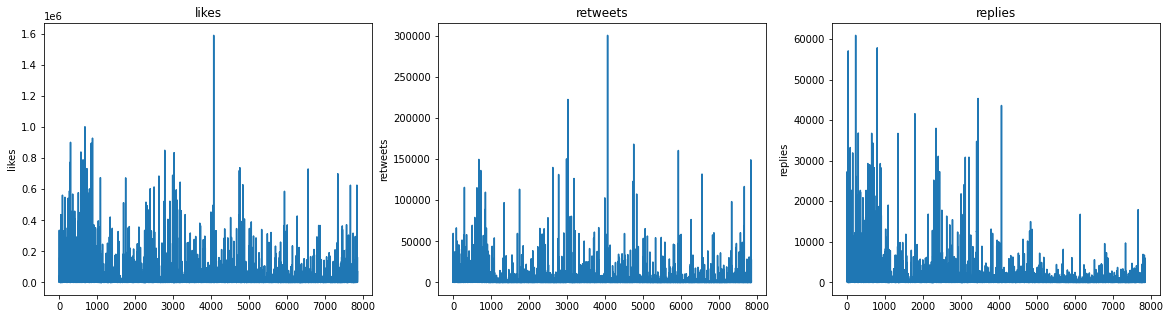

In [4]:
plt.figure(figsize=(20,5))

plt.subplot(131)
plt.plot(tweets_musk['like_count'])
plt.ylabel('likes')
plt.title('likes')

plt.subplot(132)
plt.plot(tweets_musk['retweet_count'])
plt.ylabel('retweets')
plt.title('retweets')

plt.subplot(133)
plt.plot(tweets_musk['reply_count'])
plt.ylabel('replies')
plt.title('replies')

plt.show()

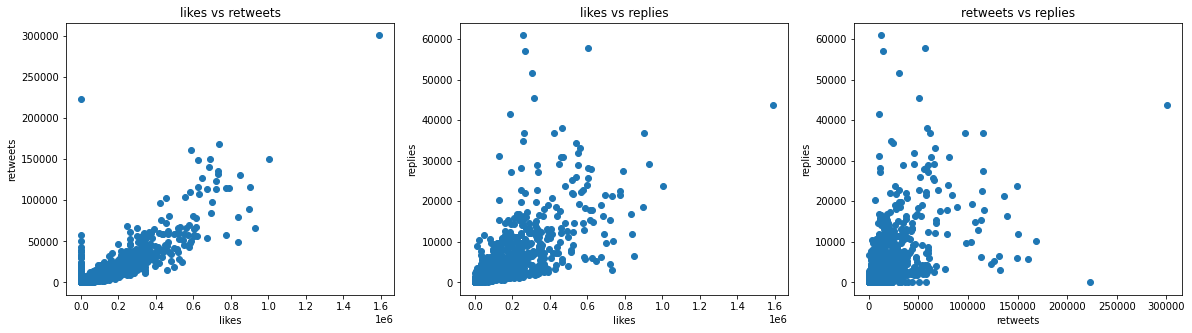

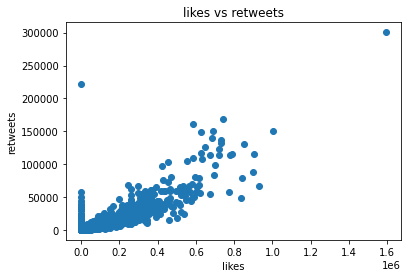

In [8]:
fig, axs = plt.subplots(1,3,figsize=(20,5))
axs[0].scatter(tweets_musk['like_count'],tweets_musk['retweet_count'])
axs[0].set_xlabel('likes');axs[0].set_ylabel('retweets')
axs[0].set_title('likes vs retweets')

axs[1].scatter(tweets_musk['like_count'],tweets_musk['reply_count'])
axs[1].set_xlabel('likes');axs[1].set_ylabel('replies')
axs[1].set_title('likes vs replies')

axs[2].scatter(tweets_musk['retweet_count'],tweets_musk['reply_count'])
axs[2].set_xlabel('retweets');axs[2].set_ylabel('replies')
axs[2].set_title('retweets vs replies')

plt.show()

plt.scatter(tweets_musk['like_count'],tweets_musk['retweet_count'])
plt.xlabel('likes')
plt.ylabel('retweets')
plt.title('likes vs retweets')

img_likeretweets = "../report/img/img_likeretweets.pdf"
plt.savefig(img_likeretweets,bbox_inches="tight")

plt.show()

Let's drop a bunch of variables that won't be considered, keeping just the date,content,fav count, retweet count

In [141]:
tweets_musk = tweets_musk.loc[:,["created_at","text","like_count","retweet_count","reply_count","quote_count"]]

In [91]:
tweets_musk.head()

,created_at,text,like_count,retweet_count,reply_count,quote_count
0,2021-04-28T08:54:22.000Z,@RationalEtienne @Erdayastronaut @Twisi80 Star...,3447,202,200,16
1,2021-04-28T08:51:43.000Z,@RiusJulien https://t.co/paTKsQjNp8,2473,131,218,22
2,2021-04-28T08:43:37.000Z,♥️\nhttps://t.co/juLuKlymEX,38250,2781,5728,257
3,2021-04-28T07:33:33.000Z,@AstroJordy @wapodavenport 0% so far,2823,135,244,27
4,2021-04-28T06:21:41.000Z,@muratpak 🔥,4783,239,263,25


Now let's do some hourly aggregation, so that we can fit the data with the rest of the data.
But since we will lose the text of the tweets by doing this, we will make 2 versions.
The first is just and aggregation "as is", whereas the 2nd one will agregate only tweets containing the word "tesla"

In [142]:
print(type(tweets_musk["created_at"][0]))
tweets_musk["created_at"]=pd.to_datetime(tweets_musk["created_at"])
print(type(tweets_musk["created_at"][0]))

<class 'str'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


temporary shifting the times to get on the US east coast time zone. Will need to do better later, like using the builtin timezone support in datetime objects

In [143]:
tweets_musk["created_at"]=tweets_musk["created_at"]+pd.to_timedelta(-4,'H')

In [94]:
tweets_musk.head(30)

,created_at,text,like_count,retweet_count,reply_count,quote_count
0,2021-04-28 04:54:22+00:00,@RationalEtienne @Erdayastronaut @Twisi80 Star...,3447,202,200,16
1,2021-04-28 04:51:43+00:00,@RiusJulien https://t.co/paTKsQjNp8,2473,131,218,22
2,2021-04-28 04:43:37+00:00,♥️\nhttps://t.co/juLuKlymEX,38250,2781,5728,257
3,2021-04-28 03:33:33+00:00,@AstroJordy @wapodavenport 0% so far,2823,135,244,27
4,2021-04-28 02:21:41+00:00,@muratpak 🔥,4783,239,263,25
5,2021-04-28 02:20:47+00:00,The Dogefather\nSNL May 8,336005,59676,27266,8289
6,2021-04-28 00:53:39+00:00,@wapodavenport Did my heart love till now? for...,2280,191,197,23
7,2021-04-28 00:44:21+00:00,"@wapodavenport Romeo + Juliet, fish tank scene",6635,320,325,35
8,2021-04-27 23:25:43+00:00,@Erdayastronaut @Twisi80 Testing header tanks....,9552,419,290,63
9,2021-04-27 19:01:26+00:00,@leastImAlive @thesheetztweetz They have an im...,4715,477,316,101


In [144]:
search = "tesla (?<!@)"
tweets_musk_tesla = tweets_musk[tweets_musk['text'].str.contains(search,case=False)]
tweets_musk_tesla = tweets_musk_tesla.reset_index().drop('index',axis=1)

In [145]:
print(type(tweets_musk.index))
print(type(tweets_musk_tesla.index))

<class 'pandas.core.indexes.range.RangeIndex'>
<class 'pandas.core.indexes.range.RangeIndex'>


In [112]:
print(len(tweets_musk_tesla))
tweets_musk_tesla.head(40)

1174


,created_at,text,like_count,retweet_count,reply_count,quote_count
0,2021-04-27 18:32:29+00:00,@garyblack00 Other companies spend money on ad...,17010,2164,1083,384
1,2021-04-26 19:15:01+00:00,"@stoolpresidente No, you do not. I have not so...",98690,13399,4757,3017
2,2021-04-26 18:54:23+00:00,"@Orangetilt Yeah, roughly 200MW/km^2 using cur...",10898,844,500,84
3,2021-04-22 16:20:50+00:00,@AstroJordy I’m staying at a friend’s place in...,3628,279,318,34
4,2021-04-22 02:02:03+00:00,@JohnnaCrider1 @WholeMarsBlog If Tesla owners ...,3719,411,228,29
5,2021-04-22 01:49:17+00:00,Tesla Solar + Powerwall battery enables consum...,172121,11409,10234,930
6,2021-04-22 01:14:54+00:00,Powerwall 2 peak &amp; steady power capability...,27218,1240,1286,92
7,2021-04-21 21:27:43+00:00,"Starting next week, Tesla Solar Panels &amp; S...",126727,8393,7703,793
8,2021-04-20 23:51:12+00:00,"@PPathole @Tesla @SpaceX I could get a job, ju...",92336,2659,1601,146
9,2021-04-17 18:32:03+00:00,Tesla with Autopilot engaged now approaching 1...,160383,13252,11606,1192


In [74]:
print(tweets_musk['created_at'].iloc[0].to_datetime64())
print(tweets_musk_tesla['created_at'].iloc[0].to_datetime64())
print(tweets_musk['created_at'].iloc[0].time())
print(type(tweets_musk['created_at'].iloc[0].time()))
print(tweets_musk['created_at'].iloc[0].time() < dt.time(hour=4))

2021-04-28T04:54:22.000000000
2021-04-27T18:32:29.000000000
04:54:22
<class 'datetime.time'>
False


##### Manual business hour grouper
because I'm having problems with the grouper function

In [97]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

#returns the business hour for which the timestamp belongs to
def which_business_hour(ts):
    bh = ts.ceil('H')
    if bh.time() > dt.time(hour=17):
        bh = bh.replace(hour=10)
        bh = bh + pd.Timedelta(days=1)
    if bh.time() < dt.time(hour=10):
        bh = bh.replace(hour=10)
    while not is_business_day(bh.date()):
        bh = bh.replace(hour=10)
        bh = bh + pd.Timedelta(days=1)
    return bh
    

test

In [98]:
print(tweets_musk_tesla['created_at'].iloc[10])
print(which_business_hour(tweets_musk_tesla['created_at'].iloc[10]))

2021-04-17 00:51:09+00:00
2021-04-19 10:00:00+00:00


Seems to work

In [146]:
tweets_musk = tweets_musk.groupby(pd.Grouper(key="created_at",freq=pd.offsets.BusinessHour(start="10:00", end="17:00"),label='right')).sum()
#tweets_musk_tesla = tweets_musk_tesla.groupby(pd.Grouper(key="created_at",freq=pd.offsets.BusinessHour(start="10:00", end="17:00"),label='right')).sum()

In [147]:
tweets_musk_tesla['created_at'] = tweets_musk_tesla['created_at'].apply(which_business_hour)
tweets_musk_tesla.head()

,created_at,text,like_count,retweet_count,reply_count,quote_count
0,2021-04-28 10:00:00+00:00,@garyblack00 Other companies spend money on ad...,17010,2164,1083,384
1,2021-04-27 10:00:00+00:00,"@stoolpresidente No, you do not. I have not so...",98690,13399,4757,3017
2,2021-04-27 10:00:00+00:00,"@Orangetilt Yeah, roughly 200MW/km^2 using cur...",10898,844,500,84
3,2021-04-22 17:00:00+00:00,@AstroJordy I’m staying at a friend’s place in...,3628,279,318,34
4,2021-04-22 10:00:00+00:00,@JohnnaCrider1 @WholeMarsBlog If Tesla owners ...,3719,411,228,29


In [148]:
tweets_musk_tesla = tweets_musk_tesla.groupby('created_at').sum()

In [150]:
tweets_musk_tesla.head()

,like_count,retweet_count,reply_count,quote_count
created_at,,,,
2019-01-01 10:00:00,73565,2946,1018,327
2019-01-03 10:00:00,32538,2347,687,143
2019-01-03 15:00:00,2230,63,21,15
2019-01-03 17:00:00,1846,129,123,71
2019-01-04 10:00:00,1171,26,68,15


In [149]:
tweets_musk = tweets_musk.tz_localize(None)
tweets_musk_tesla = tweets_musk_tesla.tz_localize(None)

In [151]:
tweets_musk.tail(30)

,like_count,retweet_count,reply_count,quote_count
created_at,,,,
2021-04-22 10:00:00,425002,26940,24361,2335
2021-04-22 11:00:00,0,0,0,0
2021-04-22 12:00:00,0,0,0,0
2021-04-22 13:00:00,0,0,0,0
2021-04-22 14:00:00,0,0,0,0
2021-04-22 15:00:00,0,0,0,0
2021-04-22 16:00:00,0,0,0,0
2021-04-23 10:00:00,628006,67298,27873,3336
2021-04-23 11:00:00,73952,2656,2498,169


In [152]:
print(type(tweets_musk.index))
print(type(tweets_musk_tesla.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


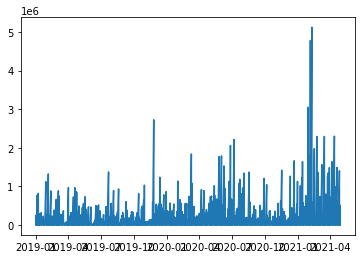

In [59]:
plt.plot(tweets_musk["like_count"])

In [83]:
file_path = '../data/twitter_musk_h.pickle'
if not os.path.isfile(file_path):
    pickle.dump(tweets_musk,open(file_path,'wb'))

In [104]:
tweets_musk_tesla.tail(30)

,like_count,retweet_count,reply_count,quote_count
created_at,,,,
2021-02-11 17:00:00,27147,790,576,39
2021-02-16 13:00:00,39597,1416,3089,170
2021-02-19 10:00:00,39573,2471,1278,229
2021-02-22 10:00:00,7451,866,408,129
2021-02-22 17:00:00,63792,2546,2253,249
2021-02-25 16:00:00,2980,154,142,14
2021-03-01 15:00:00,0,11950,0,0
2021-03-02 10:00:00,3661,173,135,9
2021-03-03 10:00:00,4651,654,240,140


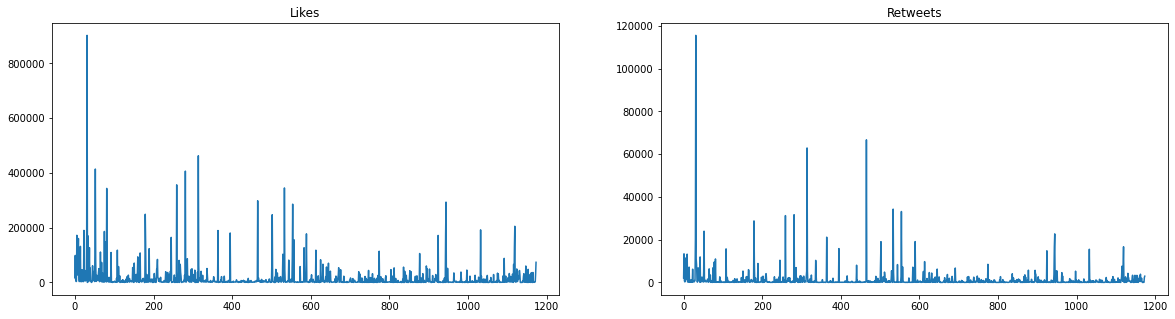

In [134]:
plt.figure(figsize=(20,5))

plt.subplot(121)
plt.plot(tweets_musk_tesla["like_count"])
plt.title('Likes')

plt.subplot(122)
plt.plot(tweets_musk_tesla['retweet_count'])
plt.title('Retweets')

plt.show()

In [153]:
file_path = '../data/twitter_musk_tesla_h.pickle'
if not os.path.isfile(file_path):
    pickle.dump(tweets_musk_tesla,open(file_path,'wb'))